In [63]:
import sys
import os
#import torch
import zarr
import fsspec
import lilio
import xarray as xr
import numpy as np
import pandas as pd
import pyarrow as pa
import matplotlib.pyplot as plt

#from torch import nn
from pathlib import Path
from scipy.stats import pearsonr, spearmanr

sys.path.append(os.path.expanduser('~/Documents/Medley'))
from scripts.prepare_monthly_ts_data import get_monthly_data

### Defining predictand
TODO: also eastern Europe. And extract both WSD and EOBS

In [3]:
# blocks to include and exclude. Lonmin, latmin, lonmax, latmax
include = {'iberia':(-9.8,35.98,3.6,43.8),
          'france_italy':(4,43,13.4,45.63)}
exclude = {'islands':(0.79,35.2,4.6,40.4),
          'north_africa':(-1.450,34.457,11.217,36.972)}

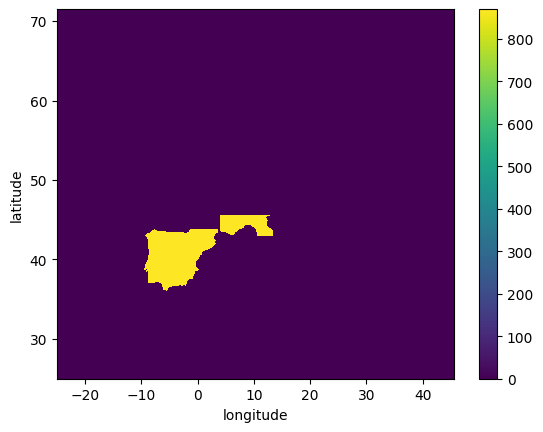

In [4]:
rrmon = xr.open_zarr('/scistor/ivm/jsn295/Medi/monthly/rr_mon_ens_mean_0.1deg_reg_v26.0e.zarr/')['rr']
example = rrmon.isel(time = 0, drop =True)
mask = xr.DataArray(np.full_like(example, 0), coords = example.coords)
def set_subset_to(lonmin, latmin, lonmax, latmax, array, value):
    lons = array.sel(longitude = slice(lonmin, lonmax)).longitude
    lats = array.sel(latitude = slice(latmin, latmax)).latitude
    array.loc[lats,lons] = value # cannot do .sel based assignment
for args in include.values():
    set_subset_to(*args, array = mask, value = 1)
for args in exclude.values():
    set_subset_to(*args, array = mask, value = 0)
count = xr.where(mask,rrmon,np.nan).count('time').compute()
count.plot()

In [65]:
df = get_monthly_data().to_pandas()
target = xr.where(mask,rrmon,np.nan).mean(['longitude','latitude']).compute().to_dataframe(name = 'rrmon')
target.columns = pd.MultiIndex.from_tuples([('rrmon',0,'EOBS')], names = df.columns.names)
df = df.loc[target.index,:]

## trends in predictors

In [66]:
cal = lilio.Calendar(anchor = '12-01')
#cal.add_intervals("target", length="1M", gap = '0M')
cal.add_intervals("precursor", length="3M", n=1, gap = '-3M') # Fully co-occurring
#cal.add_intervals("precursor", length="1M", n=3, gap = '0M')
cal.map_years(start=1949, end=2023)

Calendar(
    anchor='12-01',
    allow_overlap=False,
    mapping=('years', 1949, 2023),
    intervals=[
        Interval(role='precursor', length='3M', gap='-3M')
    ]
)

In [67]:
test = lilio.resample(cal,df, how = 'nanmean').set_index('anchor_year').iloc[:,2:-1]
test.columns = pd.MultiIndex.from_tuples(test.columns, names = df.columns.names)

/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV

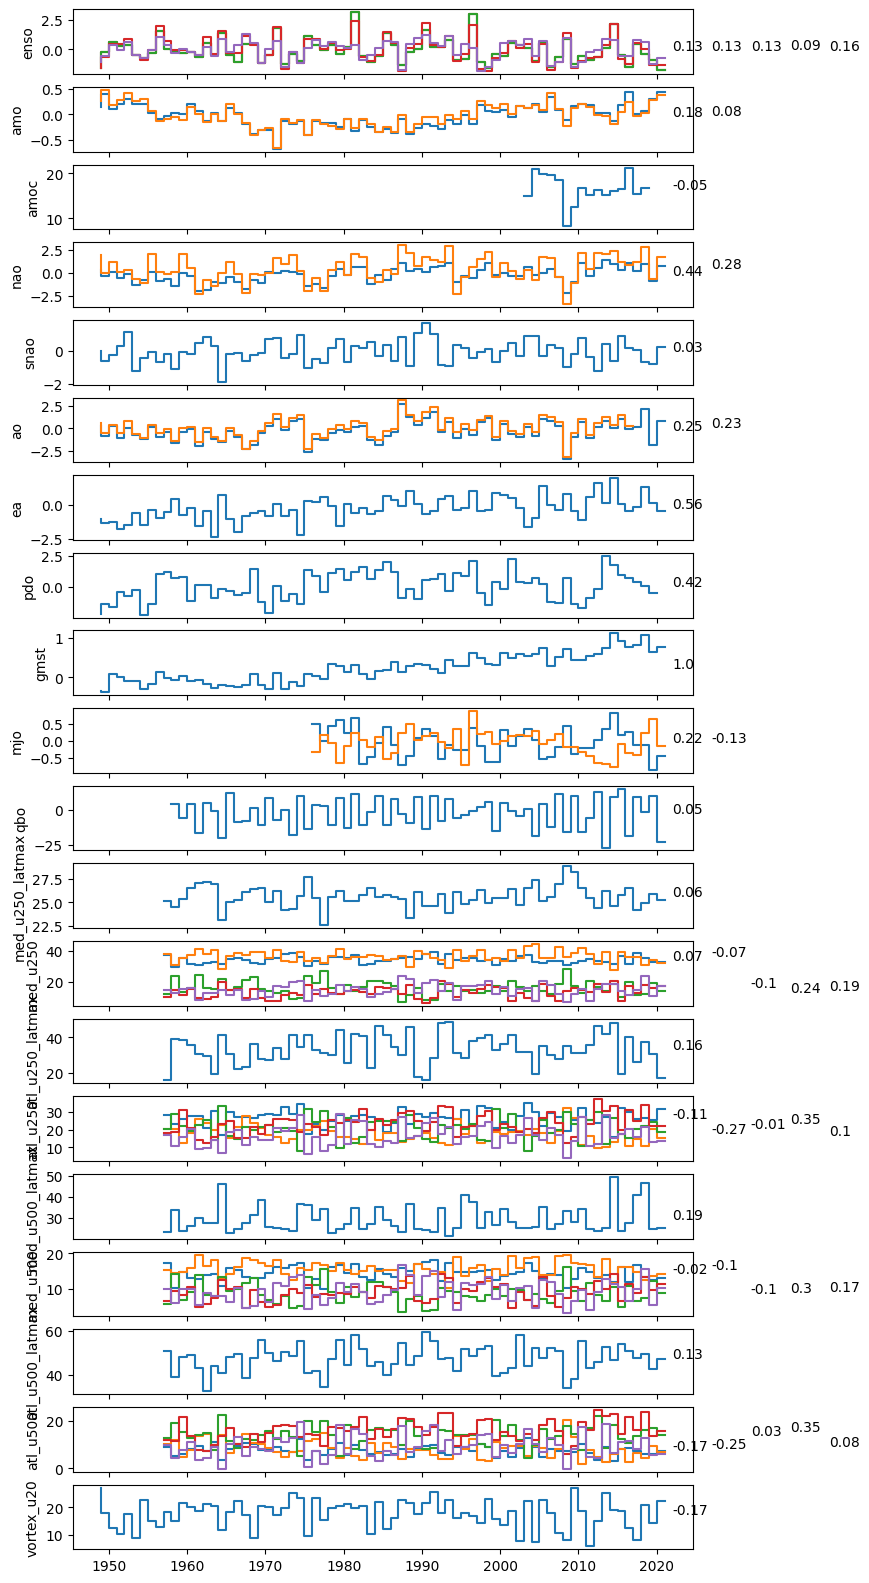

In [68]:
gmst = test['gmst'].squeeze()
names = test.columns.get_level_values('name').unique()
fig, axes = plt.subplots(nrows = len(names), sharex = True, figsize = (8,20))
for i, name in enumerate(names):
    ax = axes[i]
    dat = test.loc[:,name]
    for j,col in enumerate(dat.columns):
        series = dat[col]
        corr = pearsonr(gmst.loc[~series.isnull()],series.loc[~series.isnull()])
        ax.text(2022+5*j,series.mean(), s = np.round(corr[0],2))
        ax.step(test.index, series, label = col)
    ax.set_ylabel(name)

East Atlantic pattern pretty trended. Strong correlation with GMST
Also the blue NAO index is quite trended.

#### Correlation Matrices at multiple timescales.

In [69]:
def simultaneous_resample(firstmonth = 12, lastmonth = 1, average = True):
    """
    lastmonth is inclusive
    """
    combined = df.join(target)
    if firstmonth > lastmonth:
        months = np.arange(firstmonth - 12, lastmonth + 1, 1)
        months  = np.where(months <=0, months + 12, months)
    else:
        months = np.arange(firstmonth, lastmonth + 1, 1)
    if average:
        cal = lilio.Calendar(anchor = f'{firstmonth}-01')
        cal.add_intervals("precursor", length=f"{len(months)}M", n=1, gap = f'-{len(months)}M') # Fully co-occurring
    else:
        cal = lilio.Calendar(anchor = f'{lastmonth}-01')
        cal.add_intervals("precursor", length="1M", n=1, gap = '-1M') # Fully co-occurring
        if len(months) > 1:
            cal.add_intervals("precursor", length="1M", n=len(months)-1, gap = '0M') # Fully co-occurring
    cal.map_years(start=1949, end=2023)
    res = lilio.resample(cal, combined, how = 'nanmean')
    res = res.set_index(['anchor_year','i_interval','interval']).drop('is_target', axis = 1) # Lilio bookkeeping
    res.columns = pd.MultiIndex.from_tuples(res.columns, names = df.columns.names)
    return res

In [70]:
exampledf = simultaneous_resample(firstmonth = 1, lastmonth = 1, average = False)
# Plotting correlations per month, single months
#corwith = ('gmst',0,'hadcrut5')
corwith = ('rrmon',0,'EOBS')
othervars = exampledf.columns.drop(corwith)
months = [10,11,12,1,2,3,4,5]
corrcoefs = xr.DataArray(np.full((len(months),len(othervars)),np.nan), dims = ('month','variables'),
                        coords = {'month':months, 'variables':othervars}, name = 'spearmanr')
for month in months:
    monthly = simultaneous_resample(firstmonth = month, lastmonth = month, average = False)
    for var in othervars:
        dat = monthly.loc[:,[var,corwith]].dropna(how = 'any')
        corrcoefs.loc[month,var] = spearmanr(dat)[0]

/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV

/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV

/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV

/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV

/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV

/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV

/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV

/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV

/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV

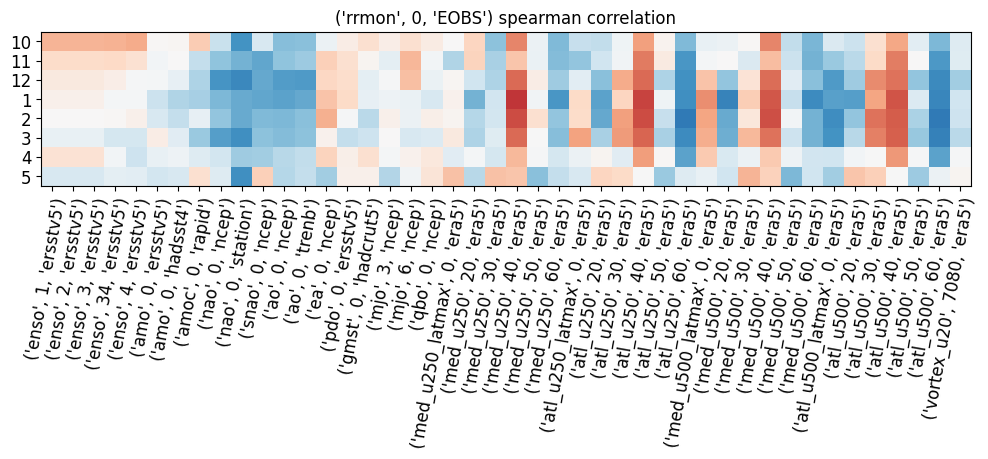

In [71]:
fig, ax = plt.subplots(figsize = (12,2))
im = ax.imshow(corrcoefs.values, vmin = -1, vmax = 1, cmap = 'RdBu_r', aspect = 'auto')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(corrcoefs.shape[1]))
ax.set_xticklabels(corrcoefs.indexes['variables'].to_flat_index().values, size = 12)
ax.set_yticks(np.arange(corrcoefs.shape[0]))
ax.set_yticklabels(corrcoefs.indexes['month'].values, size = 12)
ax.set_title(f'{corwith} spearman correlation')

plt.setp(ax.get_xticklabels(), rotation=80, ha="right",
         rotation_mode="anchor")
plt.show()

MJO phase 6 is interesting, enso in october. NAO entire winter, station based is better.

In [59]:
# Plotting correlations for multiple months aggregation, starting november
#corwith = ('gmst',0,'hadcrut5')
corwith = ('rrmon',0,'EOBS')
othervars = exampledf.columns.drop(corwith)
startmonth = 11
endmonths = [11,12,1,2,3,4]
corrcoefs = xr.DataArray(np.full((len(months),len(othervars)),np.nan), dims = ('month','variables'),
                        coords = {'month':months, 'variables':othervars}, name = 'spearmanr')
for month in endmonths:
    monthly = simultaneous_resample(firstmonth = startmonth, lastmonth = month, average = True)
    for var in othervars:
        dat = monthly.loc[:,[var,corwith]].dropna(how = 'any')
        corrcoefs.loc[month,var] = spearmanr(dat)[0]

/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV

/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV

/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV

/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV

/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV

/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV

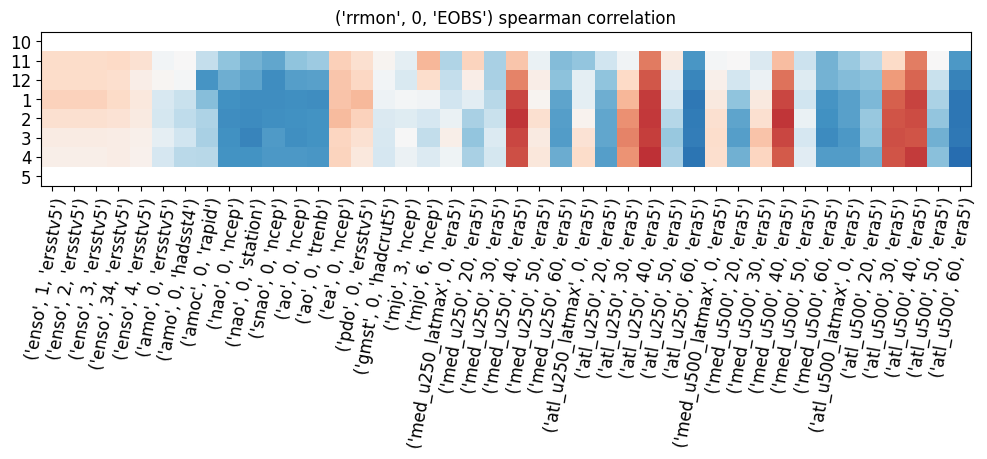

In [60]:
fig, ax = plt.subplots(figsize = (12,2))
im = ax.imshow(corrcoefs.values, vmin = -1, vmax = 1, cmap = 'RdBu_r', aspect = 'auto')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(corrcoefs.shape[1]))
ax.set_xticklabels(corrcoefs.indexes['variables'].to_flat_index().values, size = 12)
ax.set_yticks(np.arange(corrcoefs.shape[0]))
ax.set_yticklabels(corrcoefs.indexes['month'].values, size = 12)
ax.set_title(f'{corwith} spearman correlation')

plt.setp(ax.get_xticklabels(), rotation=80, ha="right",
         rotation_mode="anchor")
plt.show()

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
model = NeuralNetwork().to('cuda')

In [ ]:
model(torch.randn((784,)).to('cuda'))